In [5]:
!pip install pandas_ta
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=0597a694d7afb8586ead2f54ac847e38dd4cda6df0114f79054a3f9ed1c520df
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [6]:
import pandas_ta as ta

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from datetime import datetime, timedelta


In [7]:
stock = yf.Ticker("INFY.NS")
# get all stock info


hist = stock.history(period="1y")
data = hist

data.isnull().sum()
data.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-05-30 00:00:00+05:30,1280.979205,1292.084295,1275.280576,1289.600220,6274719,0.0,0.0
2023-05-31 00:00:00+05:30,1285.703676,1296.662623,1280.151190,1284.193848,17800782,0.0,0.0
2023-06-01 00:00:00+05:30,1288.333933,1295.104080,1283.998989,1285.362793,4277841,0.0,0.0
2023-06-02 00:00:00+05:30,1292.273341,1296.123530,1279.488867,1282.401123,10909311,17.5,0.0
2023-06-05 00:00:00+05:30,1287.337322,1292.717633,1280.722983,1287.830933,5002553,0.0,0.0


In [8]:
df = data
df = df.reset_index()
df['Date'] = df['Date'].astype(str)
df['Date'] = df['Date'].str[:10]

df.shape

(246, 8)

In [9]:
def create_ma(df, ma):
    last_ma_prices = []
    df['MA'] = np.nan
    df['std'] = np.nan
    df['prv_prices'] = 0
    for index, row in df.iterrows():
        if index < ma:
            last_ma_prices.append(row['Close'])
        else:
            df.loc[index, "MA"] = np.mean(last_ma_prices)
            df.loc[index, "std"] = np.std(last_ma_prices)
            df.loc[index, "prv_prices"] = str(last_ma_prices)
            last_ma_prices.pop(0)
            last_ma_prices.append(row['Close'])
        df.loc[index, "prv_prices"] = str(last_ma_prices)
    df['Z_'] = (df['Close'] - df['MA']) / df['std']
    df['prv_prices'] = df['prv_prices'].apply(ast.literal_eval)
    df["prv_date"] = df['Date']
    return df

In [10]:
def create_outlier(df, Z_):
    df_outliers = df[(abs(df['Z_']) >= Z_)]
    df_outliers["output"] = 0
    for index, row in df_outliers.iterrows():
        row["prv_prices"] = row["prv_prices"][-10:]
        max_ = float('-inf')
        green_price = 0
        green_date = ""
        for i in range(0, len(row["prv_prices"])):
            if abs(row["Close"] - row["prv_prices"][i]) > max_:
                max_ = abs(row["Close"] - row["prv_prices"][i])
                green_price = row["prv_prices"][i]
                temp_df = df[df["Close"] == green_price]
                green_date = temp_df.iloc[-1]["Date"]
        df_outliers.loc[index, "prv_prices"] = green_price
        df_outliers.loc[index, "prv_date"] = green_date
        if(row["Z_"] > 0):
            df_outliers.loc[index, "output"] = 1
        else:
            df_outliers.loc[index, "output"] = 0
    return df_outliers

In [11]:
df = create_ma(df, 14)

In [12]:
df_outlier2 = create_outlier(df, 2)
df_outlier2

<ipython-input-10-7e78c7e99e98>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outliers["output"] = 0


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA,std,prv_prices,Z_,prv_date,output
18,2023-06-23,1260.139213,1263.002180,1247.206631,1248.835571,7239467,0.0,0.0,1274.584490,10.704603,1288.176392,-2.405406,2023-06-13,0
22,2023-06-30,1291.483609,1321.791393,1287.781527,1318.434814,12821692,0.0,0.0,1271.242031,12.774135,1248.835571,3.694401,2023-06-23,1
23,2023-07-03,1313.005042,1328.800592,1311.474800,1316.657715,7732412,0.0,0.0,1276.146415,16.287629,1248.835571,2.487244,2023-06-23,1
24,2023-07-04,1327.122311,1328.800540,1314.387126,1327.961426,5797775,0.0,0.0,1279.090454,19.334168,1248.835571,2.527700,2023-06-23,1
25,2023-07-05,1340.499102,1340.597800,1323.864439,1330.083984,5414936,0.0,0.0,1281.932242,23.031187,1248.835571,2.090719,2023-06-23,1
32,2023-07-14,1363.007806,1411.727178,1363.007806,1407.728882,12833381,0.0,0.0,1305.935808,30.485131,1312.165894,3.339106,2023-07-10,1
33,2023-07-17,1407.728877,1440.307197,1396.227840,1404.767212,11569884,0.0,0.0,1317.285331,36.163157,1312.165894,2.419089,2023-07-10,1
34,2023-07-18,1415.676118,1459.064469,1410.740009,1456.349609,16743977,0.0,0.0,1328.046047,38.126292,1312.165894,3.365225,2023-07-10,1
35,2023-07-19,1467.011633,1479.648120,1442.034872,1456.102783,13687062,0.0,0.0,1341.870675,46.198561,1312.165894,2.472633,2023-07-10,1
54,2023-08-16,1392.772586,1401.805569,1387.441564,1400.374146,7735313,0.0,0.0,1353.551662,17.784348,1339.511963,2.632792,2023-08-02,1


In [13]:
dfout=df.copy()
dfout['prv_prices']=0
dfout['prv_date']=0
dfout['output']=0
dfout.dropna(inplace=True)
dfout['prv_date'] = pd.to_datetime(dfout['prv_date'])
df_outlier2['prv_date'] = pd.to_datetime(df_outlier2['prv_date'])
dfout['Date'] = pd.to_datetime(dfout['Date'])
df_outlier2['Date'] = pd.to_datetime(df_outlier2['Date'])

<ipython-input-13-b2fa3399b7cf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier2['prv_date'] = pd.to_datetime(df_outlier2['prv_date'])
<ipython-input-13-b2fa3399b7cf>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier2['Date'] = pd.to_datetime(df_outlier2['Date'])


In [14]:
# Merge DataFrames based on 'date' using update method
dfout.update(df_outlier2)
dfout

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA,std,prv_prices,Z_,prv_date,output
14,2023-06-19,1277.465088,1282.894808,1270.603944,1277.465088,4451787,0.0,0.0,1276.686419,11.103790,0,0.070126,1970-01-01,0
15,2023-06-20,1277.465086,1288.324526,1274.602118,1286.744995,4009180,0.0,0.0,1275.819624,10.520184,0,1.038515,1970-01-01,0
16,2023-06-21,1283.339013,1287.139914,1278.452313,1282.746704,4041529,0.0,0.0,1276.001848,10.684471,0,0.631277,1970-01-01,0
17,2023-06-22,1272.923862,1272.923862,1257.227010,1265.174194,6676607,0.0,0.0,1275.814985,10.541035,0,-1.009464,1970-01-01,0
18,2023-06-23,1260.139213,1263.002180,1247.206631,1248.835571,7239467,0.0,0.0,1274.584490,10.704603,1288.176392,-2.405406,2023-06-13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2024-05-24,1468.250000,1475.500000,1460.000000,1465.099976,5277938,0.0,0.0,1435.857152,15.400261,0,1.898852,1970-01-01,0
242,2024-05-27,1471.849976,1479.599976,1460.250000,1471.349976,5821844,0.0,0.0,1439.342861,16.086625,0,1.989673,1970-01-01,0
243,2024-05-28,1475.500000,1476.000000,1460.300049,1467.050049,6186922,0.0,0.0,1442.589286,17.564389,0,1.392634,1970-01-01,0
244,2024-05-29,1465.400024,1465.500000,1450.000000,1450.949951,7401634,0.0,0.0,1444.453578,18.643444,0,0.348453,1970-01-01,0


In [15]:
def calculate_output(df):


    df['output'] = 0  # Initialize the 'output' column with zeros
    for index, row in df.iterrows():
        date = row['Date']
        prev_date = row['prv_date']
        prev_price = row['prv_prices']
        close = row['Close']

        # Handle cases where prev_date is missing or 01-01-1970
        if prev_date == pd.to_datetime('01-01-1970'):
              continue

        # Calculate the date range for the output column (prev_date - 2 to date - 3)
        date_range = pd.date_range(start=prev_date - pd.Timedelta(days=2), end=date - pd.Timedelta(days=3))

        # Check if prev_price is greater or lesser than close
        if prev_price > close:
              value = float(2)
        elif prev_price < close:
              value = float(1)
        else:
              continue  # No change for equal values
        for output_date in date_range:
              df.loc[df['Date'] == output_date, 'output'] = value
    return df

"""        # Update the 'output' column for the date range, considering existing values
        for output_date in date_range:
          # Only update if the cell is empty or doesn't already contain +1 or -1
            print(type(df['Date']))
            if pd.isna(df.loc[df['Date'] == output_date, 'output'].values[0]) or df.loc[df['Date'] == output_date, 'output'].values[0] not in [+1, -1]:
                df.loc[df['Date'] == output_date, 'output'] = value"""




# Convert dates to datetime format (if not already done)
df['Date'] = pd.to_datetime(df['Date'])

# Calculate and add the 'output' column
dfmarking = calculate_output(dfout.copy())  # Operate on a copy to avoid modifying the original DataFrame

# Print the updated DataFrame


In [16]:
#dfmarking.to_csv("dfmark.csv")

In [17]:
df_outlier2.dtypes

Date            datetime64[ns]
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                   int64
Dividends              float64
Stock Splits           float64
MA                     float64
std                    float64
prv_prices              object
Z_                     float64
prv_date        datetime64[ns]
output                   int64
dtype: object

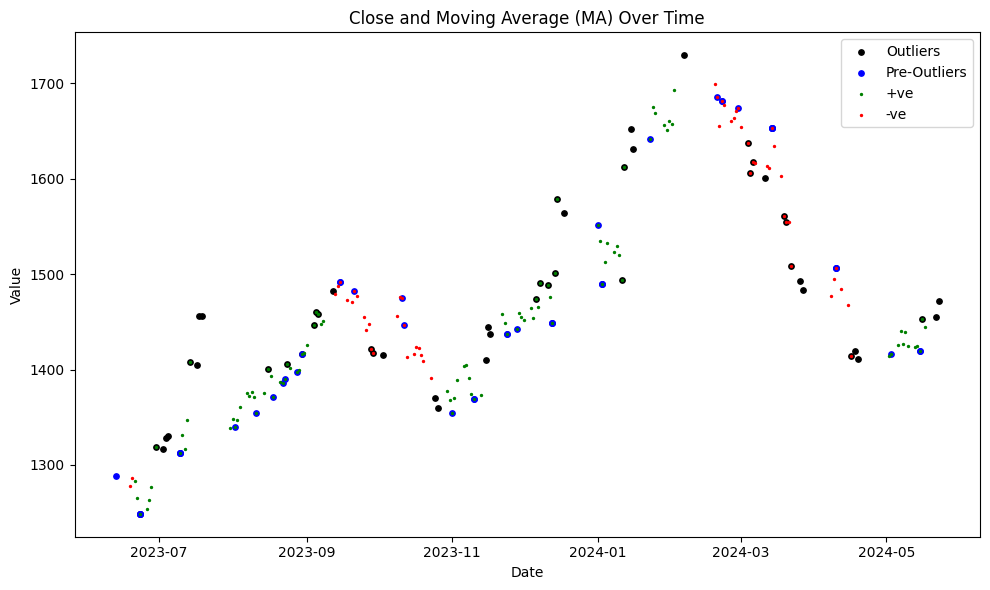

In [18]:
a=dfmarking[dfmarking['output']== 1]
b=dfmarking[dfmarking['output']==2]
plt.figure(figsize=(10, 6))
#plt.plot(df['Date'], df['Close'], label='Close')
#plt.plot(df['Date'], df['MA'], label='MA')
plt.scatter(df_outlier2['Date'], df_outlier2['Close'], label='Outliers', color='black', s=15)
plt.scatter(df_outlier2['prv_date'], df_outlier2['prv_prices'], label='Pre-Outliers', color='blue', s=15)
plt.scatter(a['Date'],a['Close'],label='+ve',color='green',s=2)
plt.scatter(b['Date'],b['Close'],label='-ve',color='red',s=2)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Close and Moving Average (MA) Over Time')
plt.legend()
plt.xticks()  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [19]:
dfout.drop(columns=['MA','std','prv_prices','Z_','prv_date'],inplace=True)
df=dfout.copy()

In [20]:
dfmarking.drop(columns=['MA','std','prv_prices','Z_','prv_date'],inplace=True)
df=dfmarking.copy()

In [ ]:
#try to run only once


In [21]:
#######
def Indicators(df):
        #relative strength index with length =14 days
        df["rsi"]=ta.rsi(close=df["Close"], length=14)

        #macd
        macd=ta.macd(close=df["Close"], fast=12,slow=26,signal=9)
        macd.columns=["MACD","DiffMaSig","Signal"]
        df=pd.concat([df,macd],axis=1)

        #adx
        adx=ta.adx(high=df["High"],low=df["Low"],close=df["Close"])
        df=pd.concat([df,adx],axis=1)

        #Rate if change
        roc=ta.roc(close=df["Close"])
        df["ROC"]=roc


        #On-balance indicator
        obv=ta.obv(close=df["Close"],volume=df["Volume"])


        #Bollinger Band
        bbands=ta.bbands(close=df["Close"])
        bbands.columns=["Lowerstd","Middlemovingavg","Upperstd","Bandwith","%columns"]
        df=pd.concat([df,bbands],axis=1)

        #aroon indicator
        aroon=ta.aroon(high=df["High"],low=df["Low"])
        aroon.columns=["Aroonup","Aroondown","Aroonoscilation"]
        df=pd.concat([df,aroon],axis=1)

        #atr(Average True Range)
        atr=ta.atr(high=df["High"],low=df["Low"],close=df["Close"])
        df["ATR"]=atr

        #on-balance Volume Indicator
        obv=ta.obv(close=df["Close"],volume=df["Volume"])
        df["OBV"]=obv


        h=df["High"]
        l=df["Low"]
        c=df["Close"]
        v=df["Volume"]

        #aberration
        abv=ta.aberration(high=h,low=l,close=c)
        df=pd.concat([df,abv],axis=1)

        #acc bands
        acc=ta.accbands(high=h,low=l,close=c)
        df=pd.concat([df,acc],axis=1)

        #Accumulation/Distribution (AD)
        ad=ta.ad(high=h,low=l,close=c,volume=v)
        df=pd.concat([df,ad],axis=1)

        #alma
        alma=ta.alma(close=c)
        df=pd.concat([df,alma],axis=1)

        #ao
        ao=ta.ao(high=h,low=l)
        df=pd.concat([df,ao],axis=1)

        #######ai##

        #hl2
        hl2=ta.hl2(high=h,low=l)
        df=pd.concat([df,hl2],axis=1)

        #hlc3
        hlc3=ta.hlc3(high=h,low=l,close=c)
        df=pd.concat([df,hlc3],axis=1)

        #donchain
        donchian=ta.donchian(high=h,low=l)
        df=pd.concat([df,donchian],axis=1)

        #stdev
        stdev=ta.stdev(close=c)
        df=pd.concat([df,stdev],axis=1)

        #natr
        natr=ta.natr(high=h,low=l,close=c)
        df=pd.concat([df,natr],axis=1)

        #cci
        cci=ta.cci(high=h,low=l,close=c)
        df=pd.concat([df,cci],axis=1)

        #sma
        sma=ta.sma(close=c)
        df=pd.concat([df,sma],axis=1)

        #cmf
        cmf=ta.cmf(high=h,low=l,close=c,volume=v)
        df=pd.concat([df,cmf],axis=1)

        #mfi money flow index
        mfi=ta.mfi(high=h,low=l,close=c,volume=v)
        df=pd.concat([df,mfi],axis=1)
        return df

In [22]:
df=Indicators(df)
df['output']=df['output'].astype(float)
df['Volume']=df['Volume'].astype(float)
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,output,rsi,...,HLC3,DCL_20_20,DCM_20_20,DCU_20_20,STDEV_30,NATR_14,CCI_14_0.015,SMA_10,CMF_20,MFI_14
14,2023-06-19,1277.465088,1282.894808,1270.603944,1277.465088,4451787.0,0.0,0.0,2.0,NaN,...,1276.987947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,2023-06-20,1277.465086,1288.324526,1274.602118,1286.744995,4009180.0,0.0,0.0,2.0,NaN,...,1283.223880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,2023-06-21,1283.339013,1287.139914,1278.452313,1282.746704,4041529.0,0.0,0.0,1.0,NaN,...,1282.779644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2023-06-22,1272.923862,1272.923862,1257.227010,1265.174194,6676607.0,0.0,0.0,1.0,NaN,...,1265.108355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,2023-06-23,1260.139213,1263.002180,1247.206631,1248.835571,7239467.0,0.0,0.0,1.0,NaN,...,1253.014794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2024-05-24,1468.250000,1475.500000,1460.000000,1465.099976,5277938.0,0.0,0.0,0.0,53.849525,...,1466.866659,1403.199951,1440.674988,1478.150024,24.678869,1.514304,162.052636,1441.709998,-0.000419,67.062173
242,2024-05-27,1471.849976,1479.599976,1460.250000,1471.349976,5821844.0,0.0,0.0,0.0,55.565623,...,1470.399984,1403.199951,1441.399963,1479.599976,23.219640,1.482171,140.503417,1446.354993,-0.026605,66.894787
243,2024-05-28,1475.500000,1476.000000,1460.300049,1467.050049,6186922.0,0.0,0.0,0.0,54.075800,...,1467.783366,1403.199951,1441.399963,1479.599976,20.187851,1.431003,105.872669,1450.715002,0.005777,59.949225
244,2024-05-29,1465.400024,1465.500000,1450.000000,1450.949951,7401634.0,0.0,0.0,0.0,48.799868,...,1455.483317,1403.199951,1441.399963,1479.599976,18.364451,1.410643,45.332678,1453.340002,-0.047109,59.101023


In [23]:
#normalising and standarlising the data######### working
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Assuming you have already read the data into a DataFrame named 'stock_data'

# Define columns for normalization and standardization
columns_to_normalize = ['Open', 'High', 'Low', 'Close', 'Volume']
columns_to_standardize = ['rsi', 'MACD', 'DiffMaSig', 'Signal', 'ADX_14',
       'DMP_14', 'DMN_14', 'ROC', 'Lowerstd', 'Middlemovingavg', 'Upperstd',
       'Bandwith', '%columns', 'Aroonup', 'Aroondown', 'Aroonoscilation',
       'ATR', 'OBV', 'ABER_ZG_5_15', 'ABER_SG_5_15', 'ABER_XG_5_15',
       'ABER_ATR_5_15', 'ACCBL_20', 'ACCBM_20', 'ACCBU_20', 'AD',
       'ALMA_10_6.0_0.85', 'AO_5_34', 'HL2', 'HLC3', 'DCL_20_20', 'DCM_20_20',
       'DCU_20_20', 'STDEV_30', 'NATR_14', 'CCI_14_0.015', 'SMA_10', 'CMF_20',
       'MFI_14', 'MACD', 'DiffMaSig', 'Signal', 'MACD', 'DiffMaSig', 'Signal',
       'MACD', 'DiffMaSig', 'Signal', 'ADX_14', 'DMP_14', 'DMN_14', 'ADX_14',
       'DMP_14', 'DMN_14']

# Step 1: Normalization of numerical features (MinMaxScaler)
scaler_minmax = MinMaxScaler()
df[columns_to_normalize] = scaler_minmax.fit_transform(df[columns_to_normalize])

# Step 2: Standardization of technical indicator features (StandardScaler)
scaler_standard = StandardScaler()
df[columns_to_standardize] = scaler_standard.fit_transform(df[columns_to_standardize])

# Step 3: Additional processing or analysis
# (You can perform further analysis or modeling on the transformed DataFrame)

# Example: Print first few rows of the transformed DataFrame
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,output,rsi,...,HLC3,DCL_20_20,DCM_20_20,DCU_20_20,STDEV_30,NATR_14,CCI_14_0.015,SMA_10,CMF_20,MFI_14
14,2023-06-19,0.049363,0.052967,0.055413,0.059569,0.050364,0.0,0.0,2.0,NaN,...,-1.768902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,2023-06-20,0.049363,0.064391,0.064462,0.078877,0.040137,0.0,0.0,2.0,NaN,...,-1.712273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,2023-06-21,0.061730,0.061899,0.073177,0.070558,0.040884,0.0,0.0,1.0,NaN,...,-1.716307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2023-06-22,0.039802,0.031988,0.025137,0.033995,0.101774,0.0,0.0,1.0,NaN,...,-1.876781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,2023-06-23,0.012886,0.011113,0.002458,0.000000,0.114781,0.0,0.0,1.0,NaN,...,-1.986603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2024-05-24,0.451031,0.458213,0.484077,0.449975,0.069455,0.0,0.0,0.0,0.117243,...,-0.044609,-0.101837,-0.451713,-0.755318,-1.265456,-0.781021,1.305705,-0.329958,-0.315784,0.870096
242,2024-05-27,0.458610,0.466840,0.484643,0.462979,0.082023,0.0,0.0,0.0,0.250975,...,-0.012522,-0.101837,-0.444196,-0.741171,-1.363737,-0.859609,1.111805,-0.285834,-0.484353,0.860471
243,2024-05-28,0.466295,0.459265,0.484756,0.454032,0.090459,0.0,0.0,0.0,0.134876,...,-0.036284,-0.101837,-0.444196,-0.741171,-1.567932,-0.984752,0.800196,-0.244418,-0.275897,0.461111
244,2024-05-29,0.445031,0.437173,0.461444,0.420533,0.118528,0.0,0.0,0.0,-0.276266,...,-0.147981,-0.101837,-0.444196,-0.741171,-1.690740,-1.034545,0.255456,-0.219483,-0.616345,0.412341


In [24]:
df2=df.copy()

In [30]:
# Assuming df is your DataFrame
corr_matrix = df2.corr()

# Getting column names where correlation > 0.80
high_corr_columns = set()  # Using a set to avoid duplicates
for col in corr_matrix.columns:
    correlated_cols = corr_matrix.index[corr_matrix[col] > 0.90].tolist()
    if col in correlated_cols:
        correlated_cols.remove(col)  # Remove the column itself from the list
    for correlated_col in correlated_cols:
        pair = (col, correlated_col) if col < correlated_col else (correlated_col, col)
        correlation_value = corr_matrix.loc[col, correlated_col]
        high_corr_columns.add((pair, correlation_value))

print("Pairs of columns with correlation > 0.80 and their correlation value:")
for pair, corr_value in high_corr_columns:
    print(f"{pair}: {corr_value}")

Pairs of columns with correlation > 0.80 and their correlation value:
('AO_5_34', 'MACD'): 0.9761773970940117
('MACD', 'Signal'): 0.9671098227111666
('DMP_14', 'rsi'): 0.9267991704317023


In [50]:
df2.drop(columns=['High','Low','Open','Middlemovingavg','HLC3','ABER_SG_5_15', 'ABER_XG_5_15','ABER_ATR_5_15','Lowerstd','SMA_10','ACCBU_20','Close','DCL_20_20','DCM_20_20','ACCBM_20','AD','ABER_ZG_5_15','ALMA_10_6.0_0.85','ACCBL_20', 'Upperstd','Dividends','Stock Splits'],inplace=True, errors = 'ignore')

In [49]:
df2

,Volume,output,rsi,MACD,DiffMaSig,Signal,ADX_14,DMP_14,DMN_14,ROC,...,ATR,OBV,AO_5_34,HL2,DCU_20_20,STDEV_30,NATR_14,CCI_14_0.015,CMF_20,MFI_14
47,-0.159091,1.0,0.301858,0.352672,-0.751683,0.566874,-0.528700,0.713622,0.737887,0.764078,...,0.333993,0.666398,0.122981,-1.411411,-0.786588,0.521242,0.558037,-0.122895,0.693978,0.102834
48,-0.732457,1.0,0.538941,0.405262,-0.418439,0.533306,-0.737522,0.863053,0.536556,0.945164,...,0.169821,0.756118,0.213309,-1.290730,-0.786588,0.361692,0.241953,0.227110,0.799319,-0.163206
49,-0.607337,1.0,0.476007,0.430480,-0.237897,0.511708,-0.923883,0.749995,0.434517,0.931464,...,-0.108719,0.655985,0.255492,-1.260935,-0.786588,0.188193,-0.213434,0.575286,0.690930,-0.400266
50,-0.627878,1.0,0.548383,0.456858,-0.089814,0.499927,-1.073287,0.685442,0.282962,0.729883,...,-0.301698,0.754409,0.308495,-1.258182,-0.786588,0.026996,-0.511663,1.041236,0.934742,-0.120725
51,-0.690845,1.0,0.416735,0.452775,-0.067110,0.489651,-1.207516,0.555155,0.168317,0.545902,...,-0.526146,0.661225,0.364919,-1.243660,-0.786588,-0.109178,-0.831529,0.819189,0.773373,1.180750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,-0.284680,0.0,0.180508,-0.414347,1.552881,-0.843621,0.064297,-0.004839,-0.745485,0.320609,...,-0.734083,-1.815034,-0.008282,-0.281741,-0.801036,-1.245232,-0.785746,1.317833,-0.264454,0.905644
242,-0.127434,0.0,0.317355,-0.314839,1.572712,-0.745179,-0.014517,-0.030382,-0.902104,0.699973,...,-0.787321,-1.674964,0.073164,-0.259677,-0.787053,-1.342995,-0.878005,1.125410,-0.430363,0.896199
243,-0.021889,0.0,0.198551,-0.249743,1.480393,-0.652858,-0.087701,-0.200744,-1.024311,0.649676,...,-0.886260,-1.823818,0.187111,-0.277683,-0.787053,-1.546115,-1.024918,0.816177,-0.225196,0.504306
244,0.329289,0.0,-0.222169,-0.251442,1.196551,-0.579355,-0.267250,-0.379608,-0.665730,0.337888,...,-0.959821,-2.001898,0.245589,-0.383187,-0.787053,-1.668276,-1.083373,0.275588,-0.560273,0.456448


In [32]:
df2.drop(columns='Date',inplace=True)
df2.columns

Index(['Volume', 'output', 'rsi', 'MACD', 'DiffMaSig', 'Signal', 'ADX_14',
       'DMP_14', 'DMN_14', 'ROC', 'Bandwith', '%columns', 'Aroonup',
       'Aroondown', 'Aroonoscilation', 'ATR', 'OBV', 'AO_5_34', 'HL2',
       'DCU_20_20', 'STDEV_30', 'NATR_14', 'CCI_14_0.015', 'CMF_20', 'MFI_14'],
      dtype='object')

In [33]:
## splitting of data
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [34]:

df2.dropna(inplace=True)
data=df2

In [35]:
data=df2
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199 entries, 47 to 245
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Volume           199 non-null    float64
 1   output           199 non-null    float64
 2   rsi              199 non-null    float64
 3   MACD             199 non-null    float64
 4   DiffMaSig        199 non-null    float64
 5   Signal           199 non-null    float64
 6   ADX_14           199 non-null    float64
 7   DMP_14           199 non-null    float64
 8   DMN_14           199 non-null    float64
 9   ROC              199 non-null    float64
 10  Bandwith         199 non-null    float64
 11  %columns         199 non-null    float64
 12  Aroonup          199 non-null    float64
 13  Aroondown        199 non-null    float64
 14  Aroonoscilation  199 non-null    float64
 15  ATR              199 non-null    float64
 16  OBV              199 non-null    float64
 17  AO_5_34          199

In [36]:
print(type(data['output']))

<class 'pandas.core.series.Series'>


In [37]:
#use or not used
scaler = StandardScaler()
feature=['Volume','rsi', 'MACD', 'DiffMaSig',
       'Signal', 'ADX_14', 'DMP_14', 'DMN_14', 'ROC', 'Bandwith', '%columns',
       'Aroonup', 'Aroondown', 'Aroonoscilation', 'ATR', 'OBV', 'AO_5_34',
       'HL2', 'DCU_20_20', 'STDEV_30', 'NATR_14', 'CCI_14_0.015', 'CMF_20',
       'MFI_14']
data[feature] = scaler.fit_transform(data[feature])
data

,Volume,output,rsi,MACD,DiffMaSig,Signal,ADX_14,DMP_14,DMN_14,ROC,...,ATR,OBV,AO_5_34,HL2,DCU_20_20,STDEV_30,NATR_14,CCI_14_0.015,CMF_20,MFI_14
47,-0.159091,1.0,0.301858,0.352672,-0.751683,0.566874,-0.528700,0.713622,0.737887,0.764078,...,0.333993,0.666398,0.122981,-1.411411,-0.786588,0.521242,0.558037,-0.122895,0.693978,0.102834
48,-0.732457,1.0,0.538941,0.405262,-0.418439,0.533306,-0.737522,0.863053,0.536556,0.945164,...,0.169821,0.756118,0.213309,-1.290730,-0.786588,0.361692,0.241953,0.227110,0.799319,-0.163206
49,-0.607337,1.0,0.476007,0.430480,-0.237897,0.511708,-0.923883,0.749995,0.434517,0.931464,...,-0.108719,0.655985,0.255492,-1.260935,-0.786588,0.188193,-0.213434,0.575286,0.690930,-0.400266
50,-0.627878,1.0,0.548383,0.456858,-0.089814,0.499927,-1.073287,0.685442,0.282962,0.729883,...,-0.301698,0.754409,0.308495,-1.258182,-0.786588,0.026996,-0.511663,1.041236,0.934742,-0.120725
51,-0.690845,1.0,0.416735,0.452775,-0.067110,0.489651,-1.207516,0.555155,0.168317,0.545902,...,-0.526146,0.661225,0.364919,-1.243660,-0.786588,-0.109178,-0.831529,0.819189,0.773373,1.180750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,-0.284680,0.0,0.180508,-0.414347,1.552881,-0.843621,0.064297,-0.004839,-0.745485,0.320609,...,-0.734083,-1.815034,-0.008282,-0.281741,-0.801036,-1.245232,-0.785746,1.317833,-0.264454,0.905644
242,-0.127434,0.0,0.317355,-0.314839,1.572712,-0.745179,-0.014517,-0.030382,-0.902104,0.699973,...,-0.787321,-1.674964,0.073164,-0.259677,-0.787053,-1.342995,-0.878005,1.125410,-0.430363,0.896199
243,-0.021889,0.0,0.198551,-0.249743,1.480393,-0.652858,-0.087701,-0.200744,-1.024311,0.649676,...,-0.886260,-1.823818,0.187111,-0.277683,-0.787053,-1.546115,-1.024918,0.816177,-0.225196,0.504306
244,0.329289,0.0,-0.222169,-0.251442,1.196551,-0.579355,-0.267250,-0.379608,-0.665730,0.337888,...,-0.959821,-2.001898,0.245589,-0.383187,-0.787053,-1.668276,-1.083373,0.275588,-0.560273,0.456448


In [38]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
# Define steps for the pipeline
steps = [
    ("scaler", StandardScaler()),  # Replace with feature scaling if needed
    ("model", RandomForestRegressor(n_estimators=200, random_state=42))  # Adjust hyperparameters
]

# Create the pipeline object
model_pipeline = Pipeline(steps=steps)


In [39]:
X = data.drop(['output'], axis=1)  # Features
y = data['output']  # Target variable

In [40]:
data['output'].nunique()

3

In [41]:
# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# K-Fold cross-validation for hyperparameter tuning (optional)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [42]:
# Train the model with cross-validation (optional)
from sklearn.model_selection import cross_val_score
# Use the model pipeline in cross-validation
#########
#scores = cross_val_score(model_pipeline, X_train, y_train, cv=cv, scoring="f1_macro")

#print(f"F1 Macro Cross-Validation Score: {scores.mean():.2f} (std: {scores.std():.2f})")
######
# Train the model on the entire training set
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestRegressor(n_estimators=200, random_state=42))])

In [43]:
# Make predictions on the test set using the trained pipeline
y_pred = model_pipeline.predict(X_test).round()

# Evaluate model performance using F1-score (macro) or other relevant metrics
from sklearn.metrics import f1_score

f1_macro = f1_score(y_test, y_pred, average="macro")
print(f"F1 Macro Test Set Score: {f1_macro:.2f}")

F1 Macro Test Set Score: 0.76


In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# Define the hyperparameter grid for GridSearchCV
param_grid = {
    "estimator__n_estimators": [25, 50, 75, 100, 200],  # Adjust hyperparameter options
    "estimator__max_depth": [5, 10, 15, 20, 25],
    "estimator__min_samples_split": [2, 5, 10],
    "estimator__min_samples_leaf": [1, 2, 4],
},

# Create the pipeline object with GridSearchCV (fix the nesting)
steps = [
    ("scaler", StandardScaler()),  # Replace with feature scaling if needed
    ("estimator", RandomForestClassifier(random_state=42))  # RandomForestRegressor directly in pipeline
]

model_pipeline = Pipeline(steps=steps)

# Wrap the pipeline with GridSearchCV
grid_search = GridSearchCV(model_pipeline, param_grid=param_grid, cv=5, scoring="f1_macro")

# Train the model with GridSearchCV on the entire training set
grid_search.fit(X_train, y_train)

# Access the best model and parameters after training
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Best Hyperparameters: {best_params}")

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Evaluate model performance using F1-score (macro) or other relevant metrics
from sklearn.metrics import f1_score

f1_macro = f1_score(y_test, y_pred, average="macro")
print(f"F1 Macro Test Set Score: {f1_macro:.2f}")

from sklearn.metrics import accuracy_score

# Assuming y_test holds the actual labels and y_pred holds the predictions
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Best Hyperparameters: {'estimator__max_depth': 10, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 100}
F1 Macro Test Set Score: 0.89
Accuracy: 0.90


In [44]:
##XG boost

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

def train_model(X_scaled, y):
#"""Trains an XGBoost model with early stopping and feature importance."""
    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    #model = XGBClassifier(objective="multi:class", num_class=3, eval_metric="mlogloss", use_label_encoder=False)
    model = XGBClassifier(objective="multi:softmax", num_class=3)
  # 'mlogloss' for multi-class classification, 'use_label_encoder=False' for preserving category information

    early_stopping_rounds = 10  # Adjust as needed
    eval_set = [(X_val, y_val)]
    model.fit(X_train, y_train, early_stopping_rounds=early_stopping_rounds, eval_set=eval_set, verbose=False)

  # Feature Importance
    feature_importance = model.feature_importances_
    feature_names = list(X_train.columns)  # Assuming column names are available
    importance_df = pd.DataFrame({"feature": feature_names, "importance": feature_importance})
    print(importance_df.sort_values(by="importance", ascending=False))

    from sklearn.metrics import accuracy_score, f1_score

    y_pred_val = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val, average="macro")

    print(f"Validation Accuracy: {accuracy:.2f}")
    print(f"Validation F1 Macro Score: {f1:.2f}")

    return model

# Example usage
if __name__ == "__main__":
    X_scaled=X
    y=y
    model = train_model(X_scaled, y)



            feature  importance
1               rsi    0.099165
19         STDEV_30    0.088719
3         DiffMaSig    0.084584
14              ATR    0.072025
11          Aroonup    0.058303
4            Signal    0.056535
23           MFI_14    0.055101
18        DCU_20_20    0.052975
8               ROC    0.044393
17              HL2    0.044356
2              MACD    0.041516
15              OBV    0.037967
0            Volume    0.031300
10         %columns    0.028578
16          AO_5_34    0.027171
5            ADX_14    0.027040
7            DMN_14    0.023222
13  Aroonoscilation    0.022241
6            DMP_14    0.021329
22           CMF_20    0.021242
21     CCI_14_0.015    0.020121
20          NATR_14    0.017282
9          Bandwith    0.015850
12        Aroondown    0.008986
Validation Accuracy: 0.88
Validation F1 Macro Score: 0.88


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [ ]:
def predict_outliers(model, X_test):
#"""Makes predictions on new data to classify outliers."""
    y_pred = model.predict(X_test)
    return y_pred

# Example usage
if __name__ == "__main__":
  # Load the model (from model_training.py)
    model = train_model(X,y)
  # Load new data for prediction (already preprocessed)
    X_test_new = X_test
    outlier_predictions = predict_outliers(model,X_test_new)

C:\Users\adity\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


            feature  importance
21     CCI_14_0.015    0.061769
17              HL2    0.053947
18        DCU_20_20    0.053016
8               ROC    0.052819
5            ADX_14    0.046495
4            Signal    0.045328
3         DiffMaSig    0.044200
20          NATR_14    0.044035
19         STDEV_30    0.043165
10         %columns    0.042990
15              OBV    0.042931
16          AO_5_34    0.042571
14              ATR    0.040340
12        Aroondown    0.040028
9          Bandwith    0.039773
7            DMN_14    0.039670
13  Aroonoscilation    0.036591
2              MACD    0.036560
22           CMF_20    0.035844
6            DMP_14    0.035769
23           MFI_14    0.033175
11          Aroonup    0.031204
1               rsi    0.030916
0            Volume    0.026867
Validation Accuracy: 0.81
Validation F1 Macro Score: 0.80


In [ ]:
outlier_predictions

array([0, 2, 1, ..., 0, 1, 2])

In [ ]:
from sklearn.metrics import accuracy_score

# Assuming y_test holds the actual labels and y_pred holds the predictions
accuracy = accuracy_score(y_test, outlier_predictions)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.96


In [ ]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # Output layer with 3 units for 0, 1, -1
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
124/124 [==============================] - 1s 5ms/step - loss: 1.0082 - accuracy: 0.4763 - val_loss: 0.9637 - val_accuracy: 0.5166
Epoch 2/10
124/124 [==============================] - 0s 3ms/step - loss: 0.9578 - accuracy: 0.5224 - val_loss: 0.9456 - val_accuracy: 0.5428
Epoch 3/10
124/124 [==============================] - 0s 3ms/step - loss: 0.9315 - accuracy: 0.5464 - val_loss: 0.9146 - val_accuracy: 0.5438
Epoch 4/10
124/124 [==============================] - 0s 3ms/step - loss: 0.9077 - accuracy: 0.5640 - val_loss: 0.9038 - val_accuracy: 0.5498
Epoch 5/10
124/124 [==============================] - 0s 2ms/step - loss: 0.8880 - accuracy: 0.5801 - val_loss: 0.8961 - val_accuracy: 0.5549
Epoch 6/10
124/124 [==============================] - 0s 2ms/step - loss: 0.8683 - accuracy: 0.6008 - val_loss: 0.8745 - val_accuracy: 0.5821
Epoch 7/10
124/124 [==============================] - 0s 2ms/step - loss: 0.8479 - accuracy: 0.6121 - val_loss: 0.8675 - val_accuracy: 0.5921
Epoch 